In [1]:
import torch 
from torch import nn, Tensor
from torchvision.ops import roi_align
import einops


        


        

In [ ]:
def create_foveated_pos_embed(
    self,
    images: Tensor,
    gaze: Tensor,
)

In [2]:
def get_nd_rotary_embed(dim, grid_shape, cls_token=False, base=10000):
    """Create n-dimensional rotary positional embeddings.

    Args:
        dim: an int of the embedding dimension.
        grid_shape: a sequence of int of the length along each axis.
        base: the base from which to calculate the rotation angles.

    Returns:
        pos_embed: a tensor of shape (grid_shape[0]*...*grid_shape[N-1], dim) of positional embeddings.

    """
    # Compute the embedding dim for each axis
    num_axis = len(grid_shape)
    assert dim % num_axis == 0
    axis_dim = dim // num_axis
    assert axis_dim % 2 == 0

    # Create meshgrid along eash axis
    axis_ticks = [torch.arange(length).float() for length in grid_shape]
    axis_grids = torch.meshgrid(*axis_ticks, indexing="ij")

    # Compute position embeddings for each axis and concatenate
    axis_thetas = [
        get_1d_rotary_embed(axis_dim, axis_grid.flatten(), base)
        for axis_grid in axis_grids
    ]
    thetas = torch.cat(axis_thetas, dim=-1)
    return thetas


def get_1d_rotary_embed(dim, pos, base=10000):
    """Create 1D rotary positional embeddings from a grid of positions.

    Args:
        dim: the output dimension for each position.
        pos: a tensor of size (seq_len,) of positions to be encoded.

    Returns:
        thetas: a tensor of size (seq_len, dim) of rotary positional embeddings.
    """
    assert dim % 2 == 0
    thetas = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
    thetas = torch.outer(pos, thetas)  # (N, D/2)
    thetas = thetas.repeat(1, 2)  # (N, D)
    return thetas

In [3]:
def crop_at_center(images: Tensor, centers: Tensor, crop_shape: tuple, out_shape: tuple = None) -> Tensor:
    if out_shape is None:
        out_shape = crop_shape
    boxes = torch.zeros(centers.shape[0], 5, device=centers.device)
    h, w = images.shape[-2:]
    new_h, new_w = crop_shape
    eye_pixel_x = ((centers[:, 0] + 1) / 2) * w
    eye_pixel_y = ((centers[:, 1] + 1) / 2) * h
    boxes[:, 0] = torch.arange(centers.shape[0], device=centers.device)
    boxes[:, 1] = eye_pixel_x - new_w / 2
    boxes[:, 2] = eye_pixel_y - new_h / 2
    boxes[:, 3] = eye_pixel_x + new_w / 2
    boxes[:, 4] = eye_pixel_y + new_h / 2     
    images = roi_align(
        images,
        boxes,
        output_size=out_shape,
    )   
    return images

In [14]:
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
# create dataset
fps = 8.33333333333333
observation_indices = [-2, -1, 0]
observation_timestamps = [i/fps for i in observation_indices]
delta_timestamps = {
    "observation.images.zed_cam_left": observation_timestamps,
    "observation.images.zed_cam_right": observation_timestamps,
    "left_eye": observation_timestamps,
    "right_eye": observation_timestamps,
}
dataset = AVAlohaDataset(
    repo_id="iantc104/av_aloha_sim_hook_package", 
    delta_timestamps=delta_timestamps,
)

In [25]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

Using cache found in /home/ianchuang/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([32, 3, 2, 3, 240, 320])
tensor([0.0328, 0.0024])


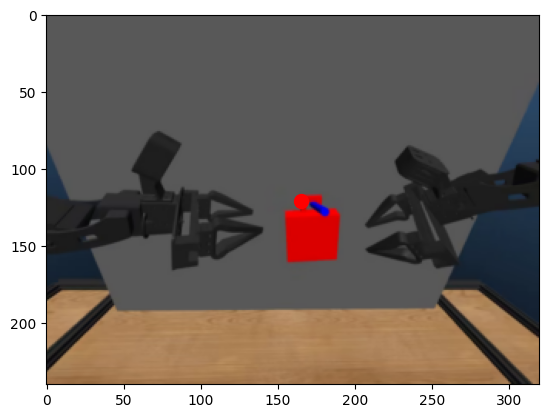

In [24]:
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
dataloader = DataLoader(
    Subset(dataset, range(200, 300)),
    batch_size=32,
    shuffle=False,
    num_workers=0,
)
batch = next(iter(dataloader))
img = torch.stack([
    batch['observation.images.zed_cam_left'],
    batch['observation.images.zed_cam_right'],
], dim=2)
gaze = torch.stack([
    batch['left_eye'],
    batch['right_eye'],
], dim=2)

print(img.shape)
print(gaze[0,0,0])
plt.imshow((img[0, 0, 0]*255).permute(1, 2, 0).cpu().numpy().astype('uint8'))
plt.scatter(
    (gaze[0, 0, 0, 0] + 1) / 2 * img.shape[-1],
    (gaze[0, 0, 0, 1] + 1) / 2 * img.shape[-2],
    c='red',
    s=100,
)
plt.show()

In [ ]:
import random

def get_nd_rotary_embed(dim, grid_shape, cls_token=False, base=10000, device='cpu'):
    """Create n-dimensional rotary positional embeddings.

    Args:
        dim: an int of the embedding dimension.
        grid_shape: a sequence of int of the length along each axis.
        base: the base from which to calculate the rotation angles.

    Returns:
        pos_embed: a tensor of shape (grid_shape[0]*...*grid_shape[N-1], dim) of positional embeddings.

    """
    # Compute the embedding dim for each axis
    num_axis = len(grid_shape)
    assert dim % num_axis == 0
    axis_dim = dim // num_axis
    assert axis_dim % 2 == 0

    # Create meshgrid along eash axis
    axis_ticks = [torch.arange(length, device=device).float() for length in grid_shape]
    axis_grids = torch.meshgrid(*axis_ticks, indexing="ij")

    # Compute position embeddings for each axis and concatenate
    axis_thetas = [
        get_1d_rotary_embed(axis_dim, axis_grid.flatten(), base, device=device)
        for axis_grid in axis_grids
    ]
    thetas = torch.cat(axis_thetas, dim=-1)
    return thetas


def get_1d_rotary_embed(dim, pos, base=10000, device='cpu'):
    """Create 1D rotary positional embeddings from a grid of positions.

    Args:
        dim: the output dimension for each position.
        pos: a tensor of size (seq_len,) of positions to be encoded.

    Returns:
        thetas: a tensor of size (seq_len, dim) of rotary positional embeddings.
    """
    assert dim % 2 == 0
    thetas = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    thetas = torch.outer(pos, thetas)  # (N, D/2)
    thetas = thetas.repeat(1, 2)  # (N, D)
    return thetas

In [ ]:
class FoveatedRoPE(nn.Module):
    def __init__(self, n_obs_steps, n_images, height, width, dim, base=10000):
        super().__init__()
        self.n_obs_steps = n_obs_steps
        self.n_images = n_images
        self.height = height
        self.width = width
        self.dim = dim

        self.register_buffer(
            'pixel_pos_embed',
            get_nd_rotary_embed(
                dim=dim,
                grid_shape=(n_obs_steps, n_images, height, width),
                cls_token=False,
                base=base,
            )
        )

    def forward(self, gaze, crop_shape, out_shape):



In [23]:
# import matplotlib.pyplot as plt
# rotary_embed = get_1d_rotary_embed(6, torch.arange(0, 20), base=10000)
# plt.imshow(rotary_embed.cpu().numpy(), cmap='viridis', aspect='auto')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import time
start_time = time.perf_counter()
rotary_embed_3d = get_nd_rotary_embed(512, (64, 2, 240, 320), base=10000, device=device)
print(f"Time taken: {time.perf_counter() - start_time:.4f} seconds")



# pos_embed = torch.zeros(64, 2, 240, 320, 512, device=device)
# x, y, h, w = 0, 0, 84, 112
# assert h % 14 == 0 and w % 14 == 0, "Height and width must be divisible by 14"

# start_time = time.perf_counter()

# x0, x1 = x - h // 2, x + h // 2
# y0, y1 = y - w // 2, y + w // 2
# # clamp to valid range
# x0 = max(0, x0)
# x1 = min(pos_embed.shape[2], x1)
# y0 = max(0, y0)
# y1 = min(pos_embed.shape[3], y1)
# y0 = max(0, y0)
# indices = torch.meshgrid(
#     torch.arange(x - h // 2, x + h // 2, 14, device=pos_embed.device),
#     torch.arange(y - w // 2, y + w // 2, 14, device=pos_embed.device),
#     indexing='ij',
# )


# crop_pos_embed = pos_embed[:, :, indices[0], indices[1], :]
# print(f"Time taken for crop: {time.perf_counter() - start_time:.4f} seconds")



Time taken: 0.2121 seconds


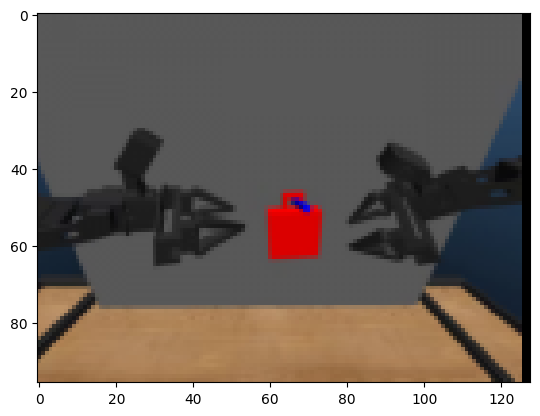

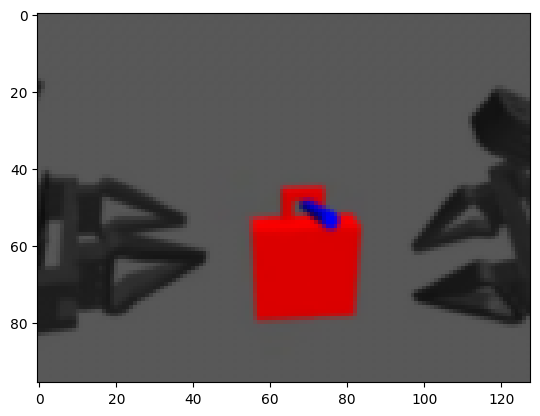

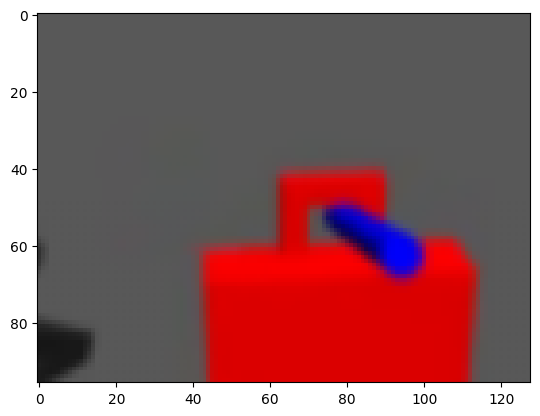

In [ ]:
out_shape = [96, 128]
scales = [1.0, 0.5, 0.2]
batch_size, n_obs_steps, n_images, channels, height, width = img.shape



crops = []
for scale in scales:
    crops.append(
        einops.rearrange(
            crop_at_center(
                images = einops.rearrange(img, 'b s n c h w -> (b s n) c h w'), 
                centers = einops.rearrange(gaze, 'b s n d -> (b s n) d'),        
                crop_shape = (int(height * scale), int(width * scale)),
                out_shape = out_shape
            ),
            '(b s n) c h w -> b s n c h w',
            b=batch_size, s=n_obs_steps, n=n_images
        )
    )
crops = torch.stack(crops, dim=3)  # (B, S, N, C, H, W)

for i in range(len(scales)):
    plt.imshow((crops[0, 0, 0, i]*255).permute(1, 2, 0).cpu().numpy().astype('uint8'))
    plt.show()



Time taken: 0.0034 seconds
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 0.8660, 0.7499,  ..., 0.0000, 0.0000, 0.0000]]],
       device='cuda:0')
torch.Size([64, 2, 384])


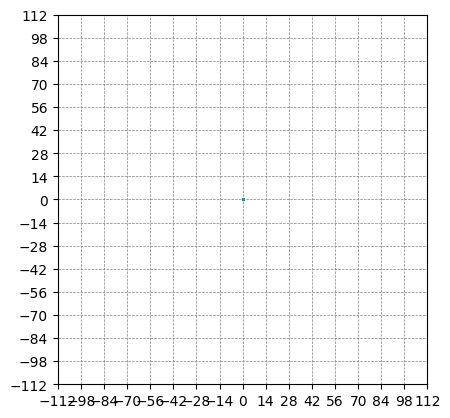

In [124]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor

def get_1d_rotary_embed(dim, pos, base=10000, device='cpu'):
    assert dim % 2 == 0
    thetas = 1.0 / (base ** (torch.arange(0, dim, 2, device=device).float() / dim))
    thetas = pos.unsqueeze(-1) * thetas
    thetas = torch.cat((thetas, thetas), dim=-1)  # (N, D)
    return thetas

def create_foveated_pos_embed(
    gaze: Tensor,
    image_shape: tuple,
    crop_shape: tuple,
    feat_shape: tuple,
    n_obs_steps: int = 1,
    dim: int = 384,
    base: int = 10000,
):
    patch_shape = (crop_shape[0] / feat_shape[0], crop_shape[1] / feat_shape[1])
    num_axis = 3
    assert dim % num_axis == 0
    axis_dim = dim // num_axis
    assert axis_dim % 2 == 0

    # Create meshgrid along eash axis
    axis_grids = list(torch.meshgrid(
        torch.arange(n_obs_steps, dtype=torch.float32, device=gaze.device),
        torch.linspace(-crop_shape[0]/2 + patch_shape[0]/2, crop_shape[0]/2 - patch_shape[0]/2, feat_shape[0], device=gaze.device),
        torch.linspace(-crop_shape[1]/2 + patch_shape[1]/2, crop_shape[1]/2 - patch_shape[1]/2, feat_shape[1], device=gaze.device),
        indexing="ij",
    ))

    gaze_x = gaze[..., 0] * image_shape[1] / 2 # (batch size , n_obs_steps)
    gaze_y = gaze[..., 1] * image_shape[0] / 2 # (batch size , n_obs_steps)

    axis_grids[0] = axis_grids[0].unsqueeze(0).expand(gaze.shape[0], -1, -1, -1)  # Expand to batch size
    axis_grids[1] = axis_grids[1].unsqueeze(0) + gaze_y.unsqueeze(-1).unsqueeze(-1)  # Adjust x-axis with gaze
    axis_grids[2] = axis_grids[2].unsqueeze(0) + gaze_x.unsqueeze(-1).unsqueeze(-1)  # Adjust y-axis with gaz
    # Compute position embeddings for each axis and concatenate
    axis_thetas = [
        get_1d_rotary_embed(axis_dim, axis_grid.flatten(start_dim=1), base, device=gaze.device)
        for axis_grid in axis_grids
    ]
    thetas = torch.cat(axis_thetas, dim=-1)

    return thetas, axis_grids
    
    
gaze = torch.zeros(64, 2, 2, device='cuda')  # (batch size, n_obs_steps, n_images, 2)
gaze[0, 0, 0] = 0
gaze[0, 0, 1] = -1
# gaze[0, 1, 0] = 0.1
# gaze[0, 1, 1] = -0.1

import time
start_time = time.perf_counter()
pos_embed, axis_grids = create_foveated_pos_embed(
    gaze=gaze,
    image_shape=(224, 224),  # (height, width)
    crop_shape=(84, 112),  # (height, width)
    feat_shape=(6,8),  # (height, width) of the feature
    n_obs_steps=2,
) 
print(f"Time taken: {time.perf_counter() - start_time:.4f} seconds")

pos_embed, axis_grids = create_foveated_pos_embed(
    gaze=torch.zeros(gaze.shape[0], gaze.shape[1], 2, device='cuda'),  # (batch size, n_obs_steps, n_images, 2)
    image_shape=(224, 224),  # (height, width)
    crop_shape=(14, 14),  # (height, width)
    feat_shape=(1,1),
    n_obs_steps=gaze.shape[1],
) 
print(pos_embed)

print(pos_embed.shape)  # Should be (S, H, W, D)

plt.scatter(
    axis_grids[2].flatten().cpu().numpy(),
    axis_grids[1].flatten().cpu().numpy(),
    s=1,
)
# draw grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
# draw ticks from -112 to 112 on both axes skip 14
plt.xticks(torch.arange(-112, 113, 14))
plt.yticks(torch.arange(-112, 113, 14))
# make equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops

def apply_rotary_embed(x, thetas):
    """Rotates the input tensors by the positional embeddings.

    Args:
        x: a tensor of shape (..., seq_len, dim).
        thetas: a tensor of shape (..., seq_len, dim) of positional embeddings.

    Returns:
        x: a tensor of shape (..., seq_len, dim) of the rotated input tensors.
    """
    assert x.shape[-2:] == thetas.shape[-2:]
    x1, x2 = x.chunk(2, dim=-1)
    x_rotate_half = torch.cat([-x2, x1], dim=-1)
    return x * thetas.cos() + x_rotate_half * thetas.sin()

def apply_rotary_embed2(x, thetas):
    x = x.permute(0, 2, 1, 3)  # [B, S, num_heads, head_dim]
    B, S, num_heads, head_dim = x.size()

    rope_cache = (self.cache[:S])
    xshaped = x.float().reshape(*x.shape[:-1], head_dim // 2, 2)
    rope_cache = rope_cache.view(1, S, num_heads, head_dim // 2, 2)

    x_out = torch.stack(
        [
            xshaped[..., 0] * rope_cache[..., 0]
            - xshaped[..., 1] * rope_cache[..., 1],
            xshaped[..., 1] * rope_cache[..., 0]
            + xshaped[..., 0] * rope_cache[..., 1],
        ],
        -1,
    )

    x_out = x_out.flatten(3)
    x_out = x_out.permute(0, 2, 1, 3)
    return x_out.type_as(x)

class Attention(nn.Module):
    """Multiheaded self-attention."""

    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        attn_drop=0.0,
        proj_drop=0.0,
        is_causal=False,
        causal_block=1,
        use_sdpa=True,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.is_causal = is_causal
        self.causal_block = causal_block

        if is_causal and causal_block > 1:
            print("Disabling torch spda kernel for block causal attention")
            self.use_sdpa = False
        else:
            self.use_sdpa = use_sdpa

        if not self.use_sdpa:
            self.causal_block_mat = nn.Parameter(
                torch.ones((causal_block, causal_block)).bool(),
                requires_grad=False,
            )

    def forward(self, x, pos_embed=None, attn_mask=None):
        B, N, D = x.shape

        # Attention mask has shape (B, N, N) and dtype torch.bool where a
        # value of True indicates that the element should take part in attention.
        if attn_mask is not None:
            assert len(attn_mask.shape) == 3
            attn_mask = attn_mask.unsqueeze(1)

        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, D // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = qkv.unbind(0)
        if pos_embed is not None:
            # transform from (B, Heads, N, D/Heads) to (B, N, Heads * D/Heads)
            q = einops.rearrange(q, 'b h n d -> b n (h d)')
            k = einops.rearrange(k, 'b h n d -> b n (h d)')
            q = apply_rotary_embed(q, pos_embed)
            k = apply_rotary_embed(k, pos_embed)
            # transform back to (B, Heads, N, D/Heads)
            q = einops.rearrange(q, 'b n (h d) -> b h n d', h=self.num_heads, d=D // self.num_heads)
            k = einops.rearrange(k, 'b n (h d) -> b h n d', h=self.num_heads, d=D // self.num_heads)

        if self.use_sdpa:
            x = F.scaled_dot_product_attention(
                q, k, v, attn_mask, dropout_p=self.attn_drop.p, is_causal=self.is_causal
            )
        else:
            attn = (q @ k.transpose(-2, -1)) / (self.head_dim**0.5)
            if self.is_causal:
                assert attn_mask is None
                assert N % self.causal_block == 0
                num_blocks = N // self.causal_block
                block_diag_mat = torch.block_diag(
                    *[self.causal_block_mat for _ in range(num_blocks)]
                )
                triu_mat = torch.triu(
                    torch.ones(N, N, device=x.device), diagonal=1
                ).bool()
                mask = torch.logical_and(~block_diag_mat, triu_mat)
                attn = attn.masked_fill(mask.view(1, 1, N, N), float("-inf"))
            if attn_mask is not None:
                attn = attn.masked_fill(~attn_mask, float("-inf"))
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, D)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class CrossAttention(nn.Module):
    """Multiheaded cross-attention."""

    def __init__(
        self,
        dim,
        num_heads=8,
        qkv_bias=False,
        attn_drop=0.0,
        proj_drop=0.0,
        use_spda=True,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.use_spda = use_spda

    def forward(self, x, c, x_pos_embed=None, c_pos_embed=None):
        B, Nx, D = x.shape
        q = (
            self.q(x)
            .reshape(B, Nx, self.num_heads, D // self.num_heads)
            .permute(0, 2, 1, 3)
        )
        if x_pos_embed is not None:
            q = apply_rotary_embed(q, x_pos_embed)

        B, Nc, D = c.shape
        kv = (
            self.kv(c)
            .reshape(B, Nc, 2, self.num_heads, D // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        k, v = kv.unbind(0)
        if c_pos_embed is not None:
            k = apply_rotary_embed(k, c_pos_embed)

        if self.use_spda:
            x = F.scaled_dot_product_attention(q, k, v, dropout_p=self.attn_drop.p)
        else:
            xattn = (q @ k.transpose(-2, -1)) / (self.head_dim**0.5)
            xattn = xattn.softmax(dim=-1)
            xattn = self.attn_drop(xattn)
            x = xattn @ v

        x = x.transpose(1, 2).reshape(B, Nx, D)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    

# set seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)



attn = Attention(
    dim=384,
    num_heads=8,
    qkv_bias=True,
    attn_drop=0.1,
    proj_drop=0.1,
    use_sdpa=True,
).cuda()
x = torch.randn(64, 10, 384).cuda()  # (batch size, sequence length, embedding dimension)
pos_embed = get_1d_rotary_embed(dim=384, pos=torch.arange(10, device='cuda'), base=10000, device='cuda').unsqueeze(0).expand(x.shape[0], -1, -1)  # (batch size, sequence length, embedding dimension)

print("Input shape:", x.shape)
print("Positional embedding shape:", pos_embed.shape)

output = attn(x, pos_embed=pos_embed)

print(output[0,:,0])
    

Input shape: torch.Size([64, 10, 384])
Positional embedding shape: torch.Size([64, 10, 384])
tensor([ 0.0254,  0.1684, -0.0445, -0.0100, -0.0344,  0.0654,  0.0591,  0.1138,
         0.0730,  0.0497], device='cuda:0', grad_fn=<SelectBackward0>)


In [99]:
class RotaryPosEmbed(nn.Module):
    """ RoPE implementation from torchtune """

    def __init__(
        self,
        dim: int,
        max_seq_len: int = 256,
        base: int = 10_000,
    ) -> None:
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_seq_len = max_seq_len
        self._rope_init()

    def _rope_init(self):
        theta = 1.0 / (
            self.base
            ** (torch.arange(0, self.dim, 2)[: (self.dim // 2)].float() / self.dim)
        )
        self.register_buffer("theta", theta, persistent=False)
        self._build_rope_cache(self.max_seq_len)

    def _build_rope_cache(self, max_seq_len: int = 256) -> None:
        seq_idx = torch.arange(max_seq_len, dtype=self.theta.dtype, device=self.theta.device)

        idx_theta = torch.einsum("i, j -> ij", seq_idx, self.theta).float()
        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        self.register_buffer("cache", cache, persistent=False)

    def forward(self, x) -> torch.Tensor:
        """
        Inputs: x: [B, num_heads, S, head_dim]
        Returns: [B, num_heads, S, head_dim]
        """
        x = x.permute(0, 2, 1, 3)  # [B, S, num_heads, head_dim]
        B, S, num_heads, head_dim = x.size()

        rope_cache = (self.cache[:S])
        xshaped = x.float().reshape(*x.shape[:-1], head_dim // 2, 2)
        rope_cache = rope_cache.view(1, S, num_heads, head_dim // 2, 2)

        x_out = torch.stack(
            [
                xshaped[..., 0] * rope_cache[..., 0]
                - xshaped[..., 1] * rope_cache[..., 1],
                xshaped[..., 1] * rope_cache[..., 0]
                + xshaped[..., 0] * rope_cache[..., 1],
            ],
            -1,
        )

        x_out = x_out.flatten(3)
        x_out = x_out.permute(0, 2, 1, 3)
        return x_out.type_as(x)
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

def apply_rope(x, rope):
    """
    Apply 1D rotary embeddings to the last two dimensions of x.
    x: (B, H, L, D)
    rope: (L, D)
    """
    # Only apply to first half (cosine/sine parts)
    x1, x2 = x[..., ::2], x[..., 1::2]
    sin, cos = rope.sin(), rope.cos()
    x_rotated = torch.stack([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
    return x_rotated.flatten(-2)

def get_1d_rope(L, dim, base=10000, device='cpu'):
    """
    Generate 1D RoPE for sequence length L and dimension dim.
    Returns a tensor of shape (L, dim)
    """
    assert dim % 2 == 0, "RoPE dimension must be even"
    pos = torch.arange(L, dtype=torch.float, device=device).unsqueeze(1)  # (L, 1)
    dim_range = torch.arange(0, dim, 2, dtype=torch.float, device=device)  # (dim/2,)
    freqs = 1.0 / (base ** (dim_range / dim))
    theta = pos * freqs  # (L, dim/2)
    return theta  # Return theta directly; caller will use sin/cos when applying

class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = dropout

    def forward(self, x, mask=None, rope=None):
        """
        x: (B, L, D)
        mask: (B, L) or (B, L, L) attention mask
        rope: (L, head_dim) optional RoPE angles
        """
        B, L, D = x.shape

        # Project to qkv and reshape to (B, num_heads, L, head_dim)
        qkv = self.qkv_proj(x)  # (B, L, 3D)
        q, k, v = qkv.chunk(3, dim=-1)

        def reshape_heads(t):
            return t.view(B, L, self.num_heads, self.head_dim).transpose(1, 2)  # (B, H, L, D_head)

        q = reshape_heads(q)
        k = reshape_heads(k)
        v = reshape_heads(v)

        if rope is not None:
            # Apply RoPE to q and k (but not v)
            q = apply_rope(q, rope)
            k = apply_rope(k, rope)

        # Use PyTorch SDPA
        attn_out = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=mask,
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=False  # you can add an argument for this
        )  # (B, H, L, D_head)

        # Merge heads and project out
        out = attn_out.transpose(1, 2).reshape(B, L, D)  # (B, L, D)
        return self.out_proj(out)


In [104]:
B, L, D = 2, 3, 16
H = 8
x = torch.randn(B, L, D)
attn = Attention(embed_dim=D, num_heads=H)

# Generate RoPE
rope = get_1d_rope(L, D // H, device=x.device)  # shape (L, D_head)
output = apply_rope(x, rope)  # Apply RoPE to x

print(output[0])

rope = RotaryPosEmbed(dim=D, max_seq_len=L, base=10000).to(x.device)
x = einops.rearrange(x, 'b l (d1 d2) -> b d1 l d2', d1=H, d2=D // H)  # Reshape to (B, L, num_heads, head_dim)
output = rope(x)  # Apply RoPE to x using the module
output = output.permute(0, 2, 1, 3).reshape(B, L, D)  # Reshape back to (B, L, D)
print(output[0])


tensor([[ 1.1436,  0.0425, -0.1287, -0.3201,  1.3021,  0.0582, -1.4115, -0.5788,
         -1.1052,  1.3300, -0.4186, -0.4383,  1.0453,  0.7566,  1.3443, -0.0058],
        [-0.2544, -1.7896, -0.4616, -0.6764, -0.3847, -0.6716,  0.3917,  0.1119,
         -0.4222,  0.0119, -1.1558, -0.4666, -1.6309,  0.9221,  0.6838,  0.6296],
        [ 0.6929,  1.5511, -1.9043,  1.2937, -0.2300, -1.1538,  1.2493,  0.5305,
          0.7606, -0.6757, -0.3178,  1.6470,  1.0786, -0.3964,  0.7414,  0.1423]])
tensor([[ 1.1436,  0.0425, -0.1287, -0.3201,  1.3021,  0.0582, -1.4115, -0.5788,
         -1.1052,  1.3300, -0.4186, -0.4383,  1.0453,  0.7566,  1.3443, -0.0058],
        [-0.2544, -1.7896, -0.7851, -0.2328, -0.7652, -0.1161,  0.3142, -0.2594,
         -0.2217,  0.3595, -1.0194,  0.7172, -0.1071,  1.8705,  0.8993, -0.2349],
        [ 0.6929,  1.5511,  0.8827,  2.1262, -1.0714,  0.4861,  0.0483, -1.3564,
         -0.9225, -0.4290,  1.6323, -0.3861, -0.8077, -0.8174, -0.1786, -0.7335]])
